In [1]:
import math
from pprint import pprint

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from utilities.storage import get_dot_product_bm25_selected_files, get_dot_product_bm25_selected_model_generated_files
from utilities.model import get_model, get_num_parameters_per_layer

In [2]:
def calculate_cosine_similarity(a_dot_b, a_dot_a, b_dot_b):
    # calculates the cosine similarity based on dot products
    return a_dot_b / (math.sqrt(a_dot_a) * math.sqrt(b_dot_b))

In [3]:
def calculate_score(gradient_similarities: dict):
    correct_counter = 0
    bm25_correct_counter = 0

    size = len(gradient_similarities.keys())

    for paraphrased_id, similarities in gradient_similarities.items():
        most_similar_original_id = max(similarities, key=similarities.get)
        correct_counter += int(paraphrased_id == most_similar_original_id)

        bm25_most_similar_original_id = list(similarities.keys())[0]
        bm25_correct_counter += int(paraphrased_id == bm25_most_similar_original_id)

    return correct_counter / size, bm25_correct_counter / size

In [4]:
def get_wrong_decisions(gradient_similarities: dict):
    wrong_decisions = []

    for original_id, similarities in gradient_similarities.items():
        most_similar_paraphrased_id = max(similarities, key=similarities.get)
        if original_id != most_similar_paraphrased_id:
            wrong_decisions.append(original_id)

    return wrong_decisions

In [5]:
def get_mean_similarity_of_most_similar_samples(gradient_similarities: dict, mean_function = np.mean):
    highest_similarities = []

    for original_id, similarities in gradient_similarities.items():
        highest_similarities.append(max(similarities.values()))

    return mean_function(highest_similarities)

In [6]:
def get_cosine_similarities(dot_product_storage_function, model_to_evaluate, sample_size):
    dot_products, paraphrased_dot_products, original_dot_products = dot_product_storage_function(model_to_evaluate, sample_size)

    # restructure such that layer is at outermost level in the dictionary for easier access afterward
    cosine_similarities_new_structure = dict()
    cosine_similarities_old_structure = dict()

    cosine_similarities_old_structure_combined = dict() # all gradients combined

    for paraphrased_id, values in dot_products.items():
        cosine_similarities_old_structure[paraphrased_id] = dict()
        cosine_similarities_old_structure_combined[paraphrased_id] = dict()

        for original_id, layers in values.items():
            cosine_similarities_old_structure[paraphrased_id][original_id] = dict()
            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = 0

            for layer, value in layers.items():
                if layer not in cosine_similarities_new_structure:
                    cosine_similarities_new_structure[layer] = dict()

                if paraphrased_id not in cosine_similarities_new_structure[layer]:
                    cosine_similarities_new_structure[layer][paraphrased_id] = dict()

                similarity = calculate_cosine_similarity(value, paraphrased_dot_products[paraphrased_id][layer], original_dot_products[original_id][layer])

                cosine_similarities_old_structure[paraphrased_id][original_id][layer] = similarity
                cosine_similarities_new_structure[layer][paraphrased_id][original_id] = similarity

                cosine_similarities_old_structure_combined[paraphrased_id][original_id] += value

            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = calculate_cosine_similarity(
                cosine_similarities_old_structure_combined[paraphrased_id][original_id],
                sum(paraphrased_dot_products[paraphrased_id].values()),
                sum(original_dot_products[original_id].values())
            )

    # check if restructuring has worked by comparing iteratively with gradient_similarities dictionary
    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            for original_id, similarity in original_ids.items():
                assert similarity == cosine_similarities_old_structure[paraphrased_id][original_id][layer]

    return cosine_similarities_new_structure, cosine_similarities_old_structure, cosine_similarities_old_structure_combined

In [7]:
def calculate_accuracy_per_layer(cosine_similarities_new_structure: dict):
    correct_counter_per_layer = defaultdict(int)

    # amount of paraphrased_samples
    size = len(next(iter(cosine_similarities_new_structure.values())).keys())

    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            most_similar_original_id = max(original_ids, key=original_ids.get)
            correct_counter_per_layer[layer] += int(paraphrased_id == most_similar_original_id)

        # divide by size to get percentage
        correct_counter_per_layer[layer] /= size

    return correct_counter_per_layer

In [30]:
pprint(list(cosine_similarities_old_structure_combined.values())[0], indent=4)

{   'lima_0': 0.5719717786853517,
    'lima_110': 0.004948505967248533,
    'lima_266': -0.012456483036078275,
    'lima_451': 0.006372746412397224,
    'lima_947': 0.00106307573875359}


In [31]:
def calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(
        similarities_per_layer_new_structure: dict[str, dict[str, dict[str, float]]],
        similarities_full_gradient_old_structure: dict[str, dict[str, float]],
):
    # compare each layer with the full gradient

    # flatten full gradient similarities for comparisons
    full_flattened = [item for values in similarities_full_gradient_old_structure.values() for item in values.values()]

    layer_similarity_compared_to_full_gradients = dict()

    for layer, similarities in similarities_per_layer_new_structure.items():
        layer_cosine_similarities_flattened = []

        for paraphrased_id, original_similarities in similarities.items():
            layer_cosine_similarities_flattened.extend(original_similarities.values())

        layer_similarity_compared_to_full_gradients[layer] = cosine_similarity(X=[layer_cosine_similarities_flattened], Y=[full_flattened])[0][0]

    return layer_similarity_compared_to_full_gradients

In [8]:
#model_to_evaluate = "amd/AMD-OLMo-1B-SFT"
model_to_evaluate = "allenai/OLMo-7B-SFT-hf"
sample_size = 100

#model_to_evaluate = "openai-community/gpt2"
#sample_size = 3

In [9]:
model = get_model(model_to_evaluate)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Device: cpu
Model parameters: 6888095744
OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 4096, padding_idx=1)
    (layers): ModuleList(
      (0-31): 32 x OlmoDecoderLayer(
        (self_attn): OlmoAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): OlmoMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
    (rotary_e

In [10]:
num_parameters_per_layer = get_num_parameters_per_layer(model)

pprint(num_parameters_per_layer, indent=4, sort_dicts=False)

{   'model.embed_tokens.weight': 206045184,
    'model.layers.0.self_attn.q_proj.weight': 16777216,
    'model.layers.0.self_attn.k_proj.weight': 16777216,
    'model.layers.0.self_attn.v_proj.weight': 16777216,
    'model.layers.0.self_attn.o_proj.weight': 16777216,
    'model.layers.0.mlp.gate_proj.weight': 45088768,
    'model.layers.0.mlp.up_proj.weight': 45088768,
    'model.layers.0.mlp.down_proj.weight': 45088768,
    'model.layers.1.self_attn.q_proj.weight': 16777216,
    'model.layers.1.self_attn.k_proj.weight': 16777216,
    'model.layers.1.self_attn.v_proj.weight': 16777216,
    'model.layers.1.self_attn.o_proj.weight': 16777216,
    'model.layers.1.mlp.gate_proj.weight': 45088768,
    'model.layers.1.mlp.up_proj.weight': 45088768,
    'model.layers.1.mlp.down_proj.weight': 45088768,
    'model.layers.2.self_attn.q_proj.weight': 16777216,
    'model.layers.2.self_attn.k_proj.weight': 16777216,
    'model.layers.2.self_attn.v_proj.weight': 16777216,
    'model.layers.2.self_a

[]

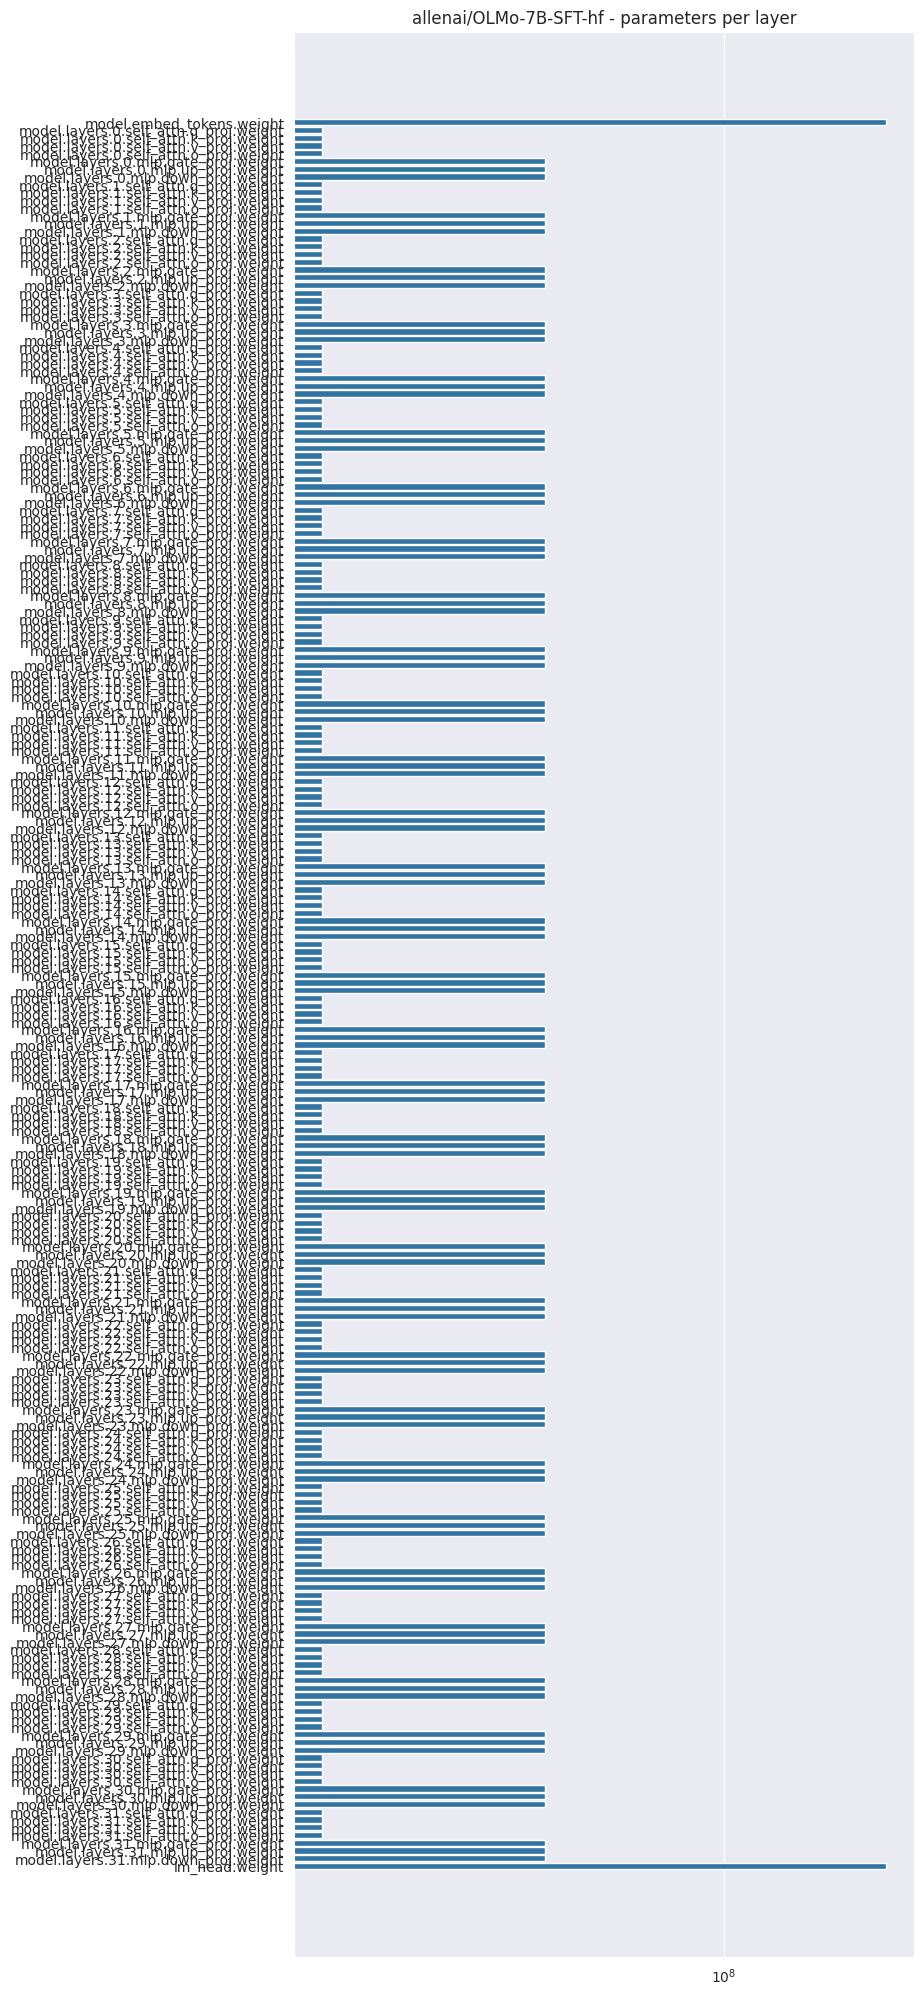

In [11]:
plt.figure(figsize=(8, 25))
sns.barplot(y = list(num_parameters_per_layer.keys()), x = list(num_parameters_per_layer.values()), orient="h")
plt.title(f"{model_to_evaluate} - parameters per layer")
plt.xscale("log")
plt.plot()

In [12]:
cosine_similarities_new_structure, cosine_similarities_old_structure, cosine_similarities_old_structure_combined = get_cosine_similarities(get_dot_product_bm25_selected_files, model_to_evaluate, sample_size)

# 1. BM25 Selected

In [13]:
model_score, bm25_score = calculate_score(cosine_similarities_old_structure_combined)
wrong_decisions = get_wrong_decisions(cosine_similarities_old_structure_combined)
mean_similarity = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined)
mean_similarity_score_median = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined, np.median)

print(f"Model score: {model_score}")
print(f"BM25 score: {bm25_score}")
print(f"Mean similarity (average): {mean_similarity}")
print(f"Mean similarity (median): {mean_similarity_score_median}")

Model score: 1.0
BM25 score: 0.99
Mean similarity (average): 0.4714987684084723
Mean similarity (median): 0.4594666335111048


## 1.1 Layer Analysis

In [14]:
accuracy_per_layer = calculate_accuracy_per_layer(cosine_similarities_new_structure)

[]

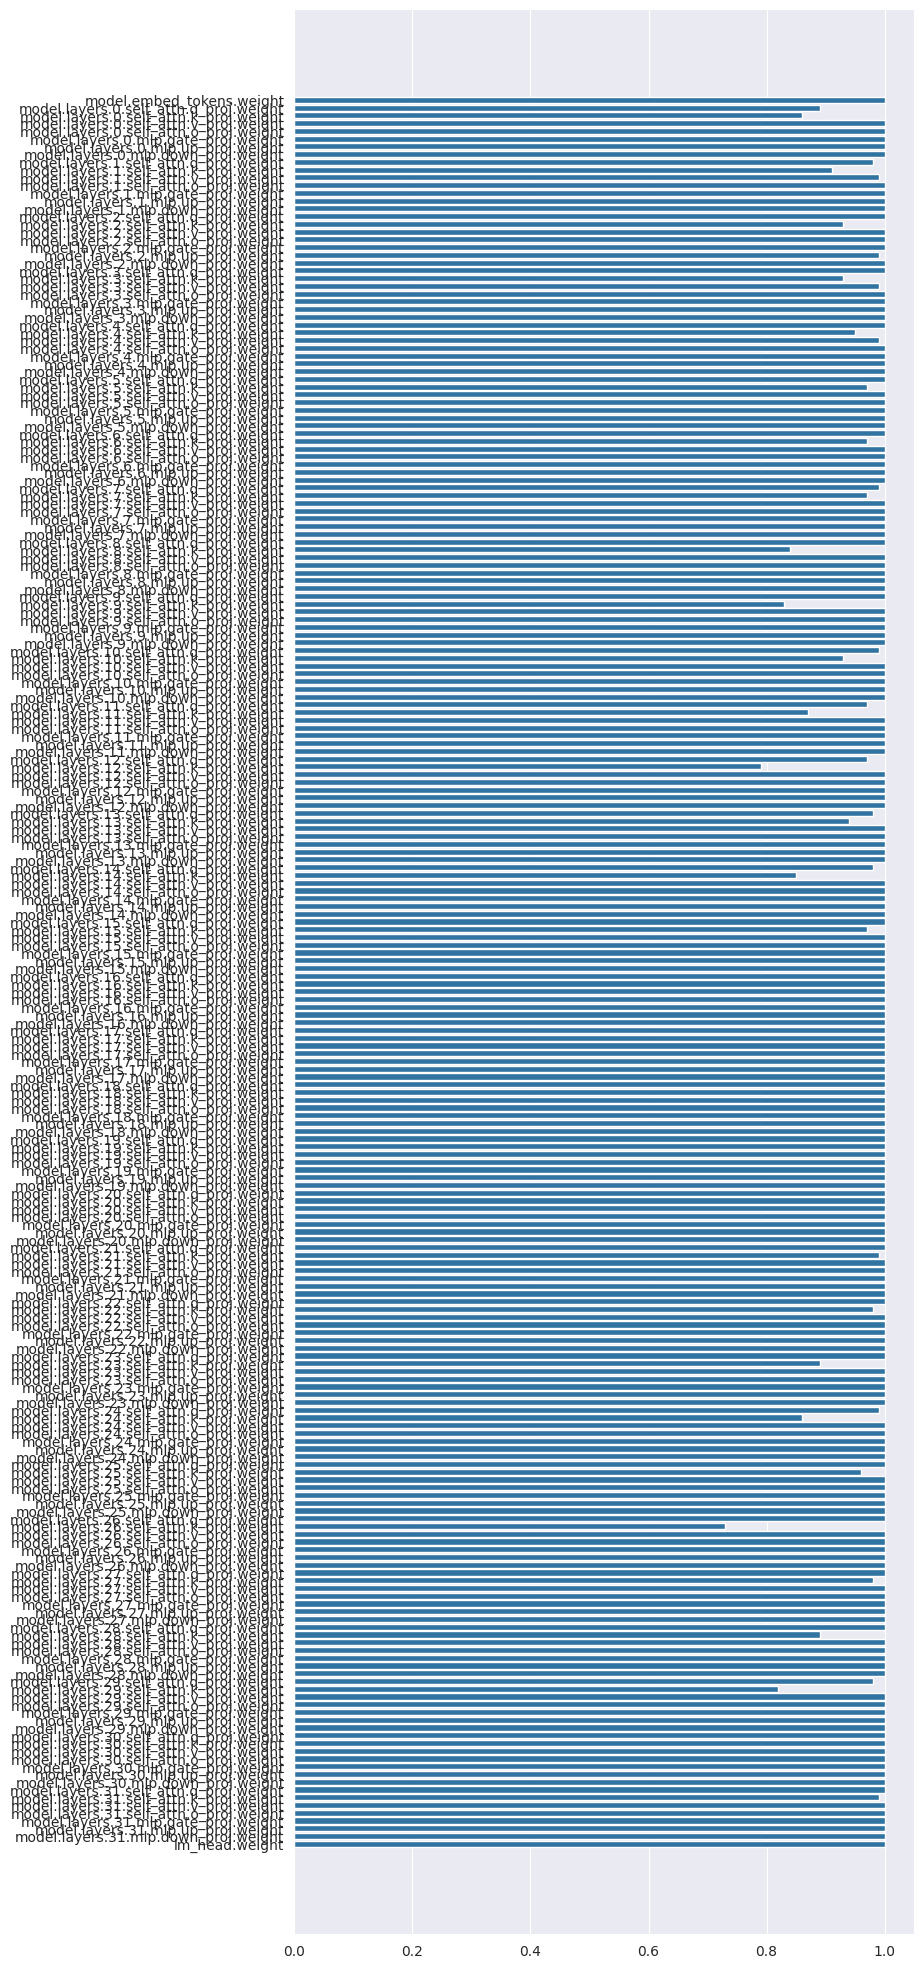

In [15]:
plt.figure(figsize=(8, 25))
sns.barplot(y = list(accuracy_per_layer.keys()), x = list(accuracy_per_layer.values()), orient="h")
plt.plot()

## 1.2 Comparison between Layer-Gradient-Similarities and Full-Gradient-Similarities

In [32]:
layer_similarity_compared_to_full_gradients = calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(cosine_similarities_new_structure, cosine_similarities_old_structure_combined)

In [33]:
max(layer_similarity_compared_to_full_gradients, key=layer_similarity_compared_to_full_gradients.get)

'model.layers.14.mlp.down_proj.weight'

[]

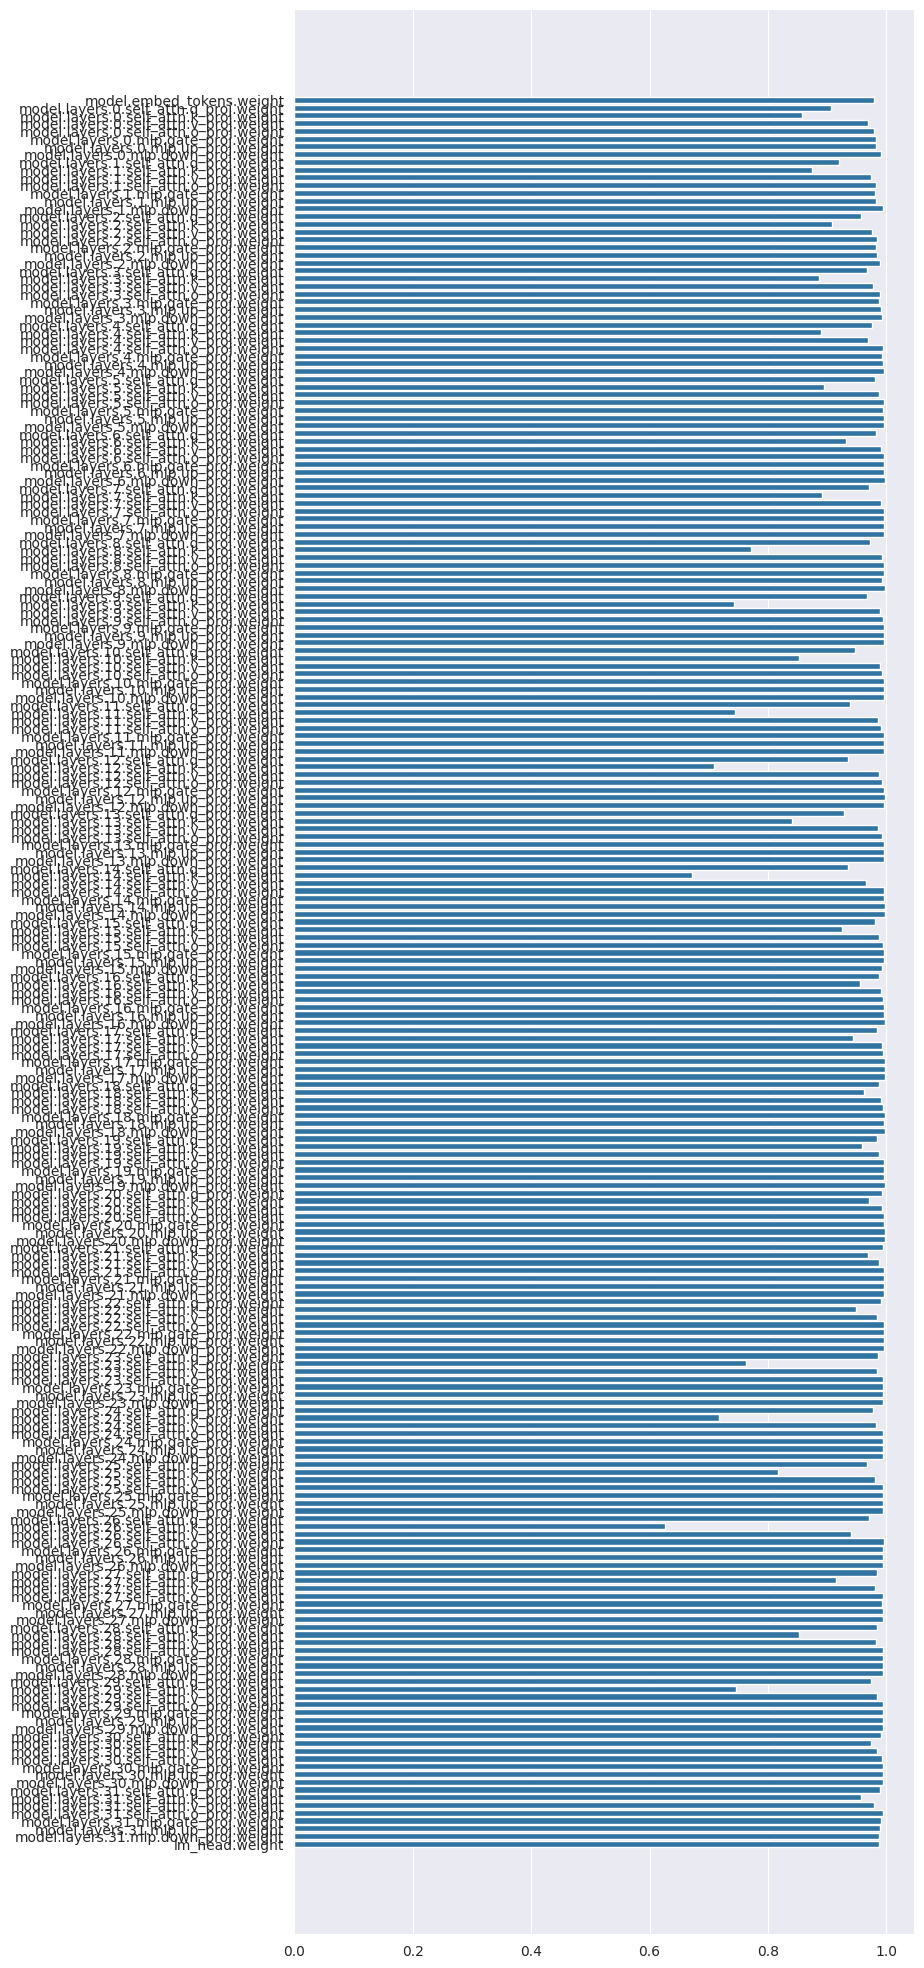

In [34]:
plt.figure(figsize=(8, 25))
sns.barplot(y = list(layer_similarity_compared_to_full_gradients.keys()), x = list(layer_similarity_compared_to_full_gradients.values()), orient="h")
plt.plot()

# 2. BM25 Selected Model Generated

In [19]:
cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_model_generated, cosine_similarities_old_structure_combined_model_generated = get_cosine_similarities(get_dot_product_bm25_selected_model_generated_files, model_to_evaluate, sample_size)

In [20]:
model_score_model_generated, bm25_score_model_generated = calculate_score(cosine_similarities_old_structure_combined_model_generated)
wrong_decisions_model_generated = get_wrong_decisions(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_score_median_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated, np.median)

print(f"Model score: {model_score_model_generated}")
print(f"BM25 score: {bm25_score_model_generated}")
print(f"Mean similarity (average): {mean_similarity_model_generated}")
print(f"Mean similarity (median): {mean_similarity_score_median_model_generated}")

Model score: 0.22
BM25 score: 0.99
Mean similarity (average): 0.06274017872822366
Mean similarity (median): 0.06004889246600584


## 2.1 Layer Analysis

In [24]:
accuracy_per_layer_model_generated = calculate_accuracy_per_layer(cosine_similarities_new_structure_model_generated)

[]

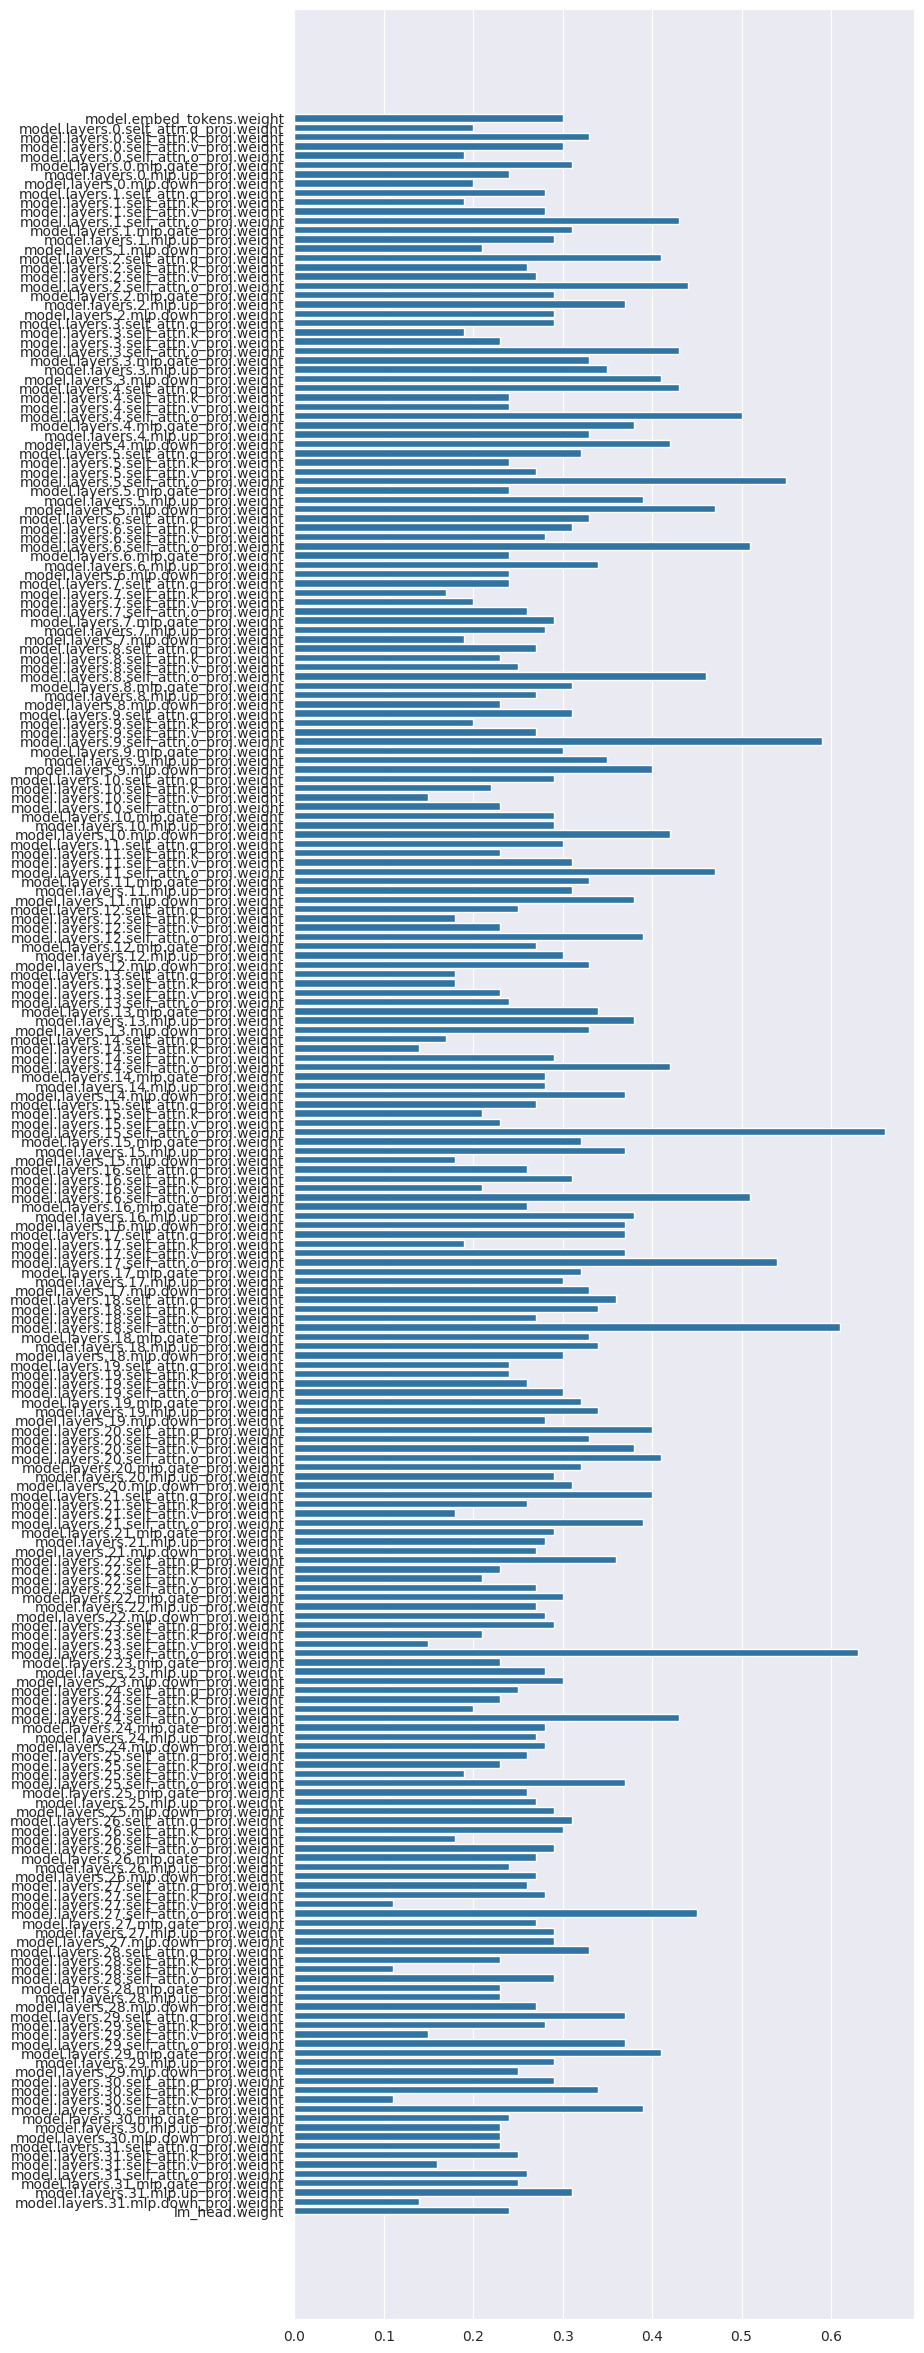

In [25]:
plt.figure(figsize=(8, 30))
sns.barplot(y = list(accuracy_per_layer_model_generated.keys()), x = list(accuracy_per_layer_model_generated.values()), orient="h")
plt.plot()

## 1.2 Comparison between Layer-Gradient-Similarities and Full-Gradient-Similarities

In [36]:
layer_similarity_compared_to_full_gradients_model_generated = calculate_similarity_between_single_layer_gradient_similarity_and_full_gradient_similarity(cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_combined_model_generated)

In [37]:
max(layer_similarity_compared_to_full_gradients_model_generated, key=layer_similarity_compared_to_full_gradients_model_generated.get)

'model.layers.14.mlp.down_proj.weight'

[]

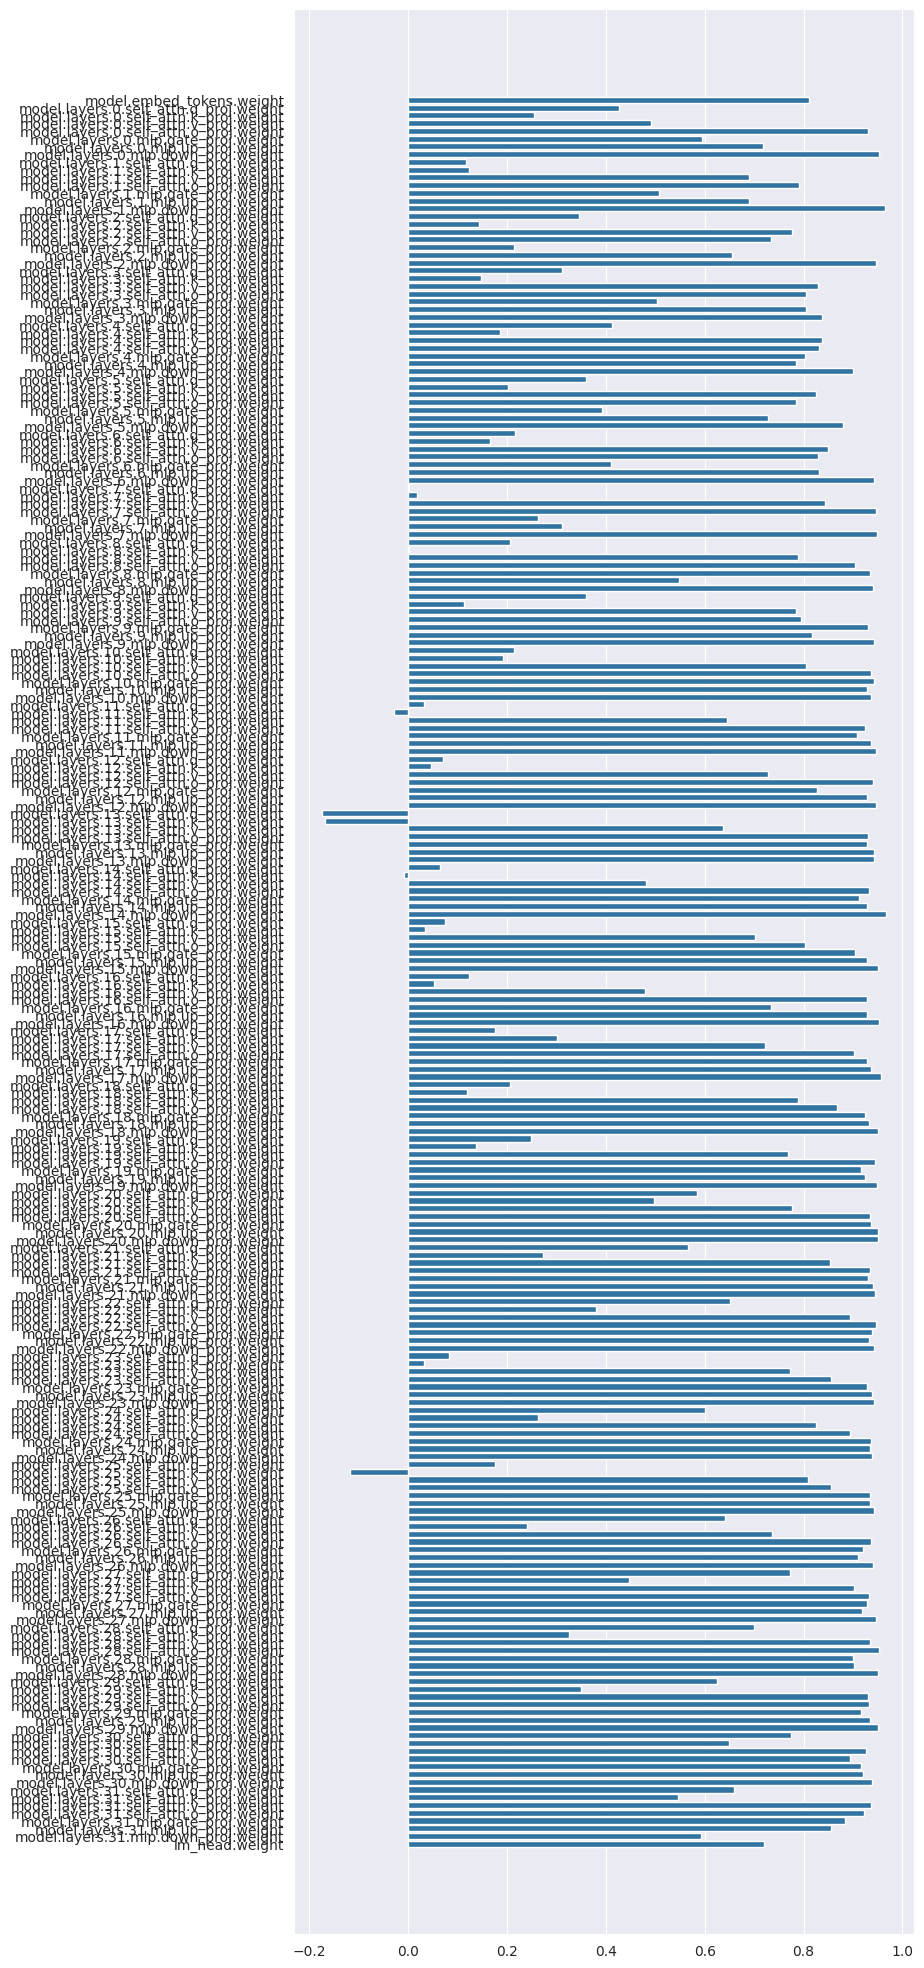

In [38]:
plt.figure(figsize=(8, 25))
sns.barplot(y = list(layer_similarity_compared_to_full_gradients_model_generated.keys()), x = list(layer_similarity_compared_to_full_gradients_model_generated.values()), orient="h")
plt.plot()

# 3. Accuracy Comparison

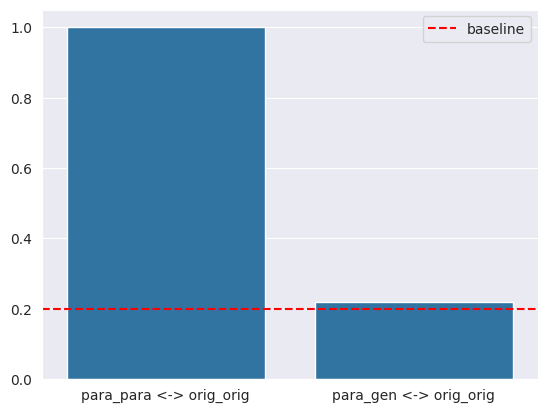

In [26]:
# create bar plot with paraphrased_score, paraphrased_model_generated_score, and horizontal line at 0.2 baseline
sns.barplot(x=["para_para <-> orig_orig", "para_gen <-> orig_orig"], y=[model_score, model_score_model_generated])

plt.axhline(y=0.2, color='r', linestyle='--', label="baseline")
plt.legend()
plt.show()

# 4. Numerical Inaccuracies

In [13]:
a = np.array(list(cosine_similarities_old_structure_combined["lima_0"].values()))
b = np.array(list(cosine_similarities_old_structure_combined["lima_0"].values()))

similarity = cosine_similarity(X=a.reshape(1, -1), Y=b.reshape(1, -1))

print(similarity)
print(similarity[0][0])

[[1.]]
0.9999999999999997


<img src="images/numeric_inaccuracies.png">

In [12]:
pprint(cosine_similarities_old_structure_combined, indent=4, sort_dicts=False)

{   'lima_0': {   'lima_0': 0.543149617675471,
                  'lima_451': 0.019011601541314625,
                  'lima_266': -0.007782182334886855,
                  'lima_947': 0.03477175810341472,
                  'lima_110': 0.0919314673549259},
    'lima_1': {   'lima_1': 0.5040566408410335,
                  'lima_122': 0.05884385681214322,
                  'lima_22': -0.006850888517972179,
                  'lima_337': 0.04565171222971818,
                  'lima_290': 0.010580813582932933},
    'lima_2': {   'lima_2': 0.8746565012016682,
                  'lima_162': 0.1442209479522065,
                  'lima_44': 0.06581968878305666,
                  'lima_1': 0.009595156058502512,
                  'lima_94': 0.032934485305843995}}
